In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('M890831.csv')

In [3]:
df = df.dropna()

In [4]:
df = df.transpose()

In [5]:
df.columns = ['Date', 'Generation']

In [6]:
df = df.iloc[1:]

In [7]:
df

,Date,Generation
Unnamed: 1,2022 Aug,4921.3
Unnamed: 2,2022 Jul,4952.4
Unnamed: 3,2022 Jun,4738.8
Unnamed: 4,2022 May,4968.7
Unnamed: 5,2022 Apr,4716.2
...,...,...
Unnamed: 568,1975 May,351.4
Unnamed: 569,1975 Apr,348.6
Unnamed: 570,1975 Mar,342.8
Unnamed: 571,1975 Feb,289.6


In [8]:
df = df[~df['Date'].str.endswith('13')]

In [9]:
df

,Date,Generation
Unnamed: 1,2022 Aug,4921.3
Unnamed: 2,2022 Jul,4952.4
Unnamed: 3,2022 Jun,4738.8
Unnamed: 4,2022 May,4968.7
Unnamed: 5,2022 Apr,4716.2
...,...,...
Unnamed: 568,1975 May,351.4
Unnamed: 569,1975 Apr,348.6
Unnamed: 570,1975 Mar,342.8
Unnamed: 571,1975 Feb,289.6


In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df['Generation'] = pd.to_numeric(df['Generation'])

In [12]:
df.dtypes

Date          datetime64[ns]
Generation           float64
dtype: object

In [13]:
df = df.set_index('Date')

In [14]:
df

,Generation
Date,
2022-08-01,4921.3
2022-07-01,4952.4
2022-06-01,4738.8
2022-05-01,4968.7
2022-04-01,4716.2
...,...
1975-05-01,351.4
1975-04-01,348.6
1975-03-01,342.8


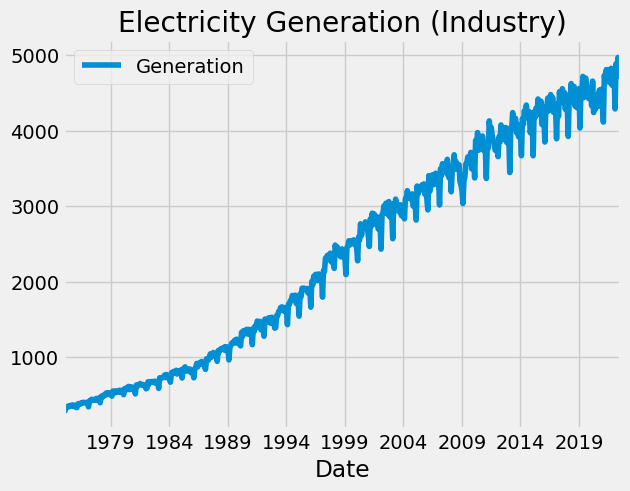

In [15]:
df.plot()
plt.title('Electricity Generation (Industry)')
plt.show()

## Stationarity


#### Three criteria:
 - Zero Trend, it isn't growing or shrinking
 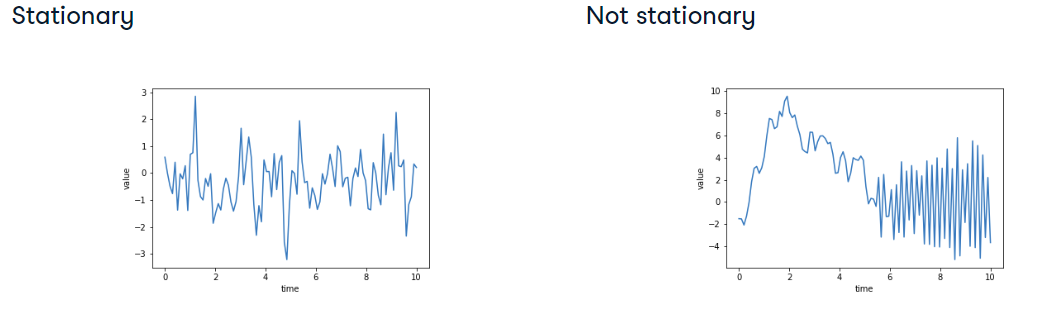
 - Variance is constant, the avg distance of data points from the zero line isn't changing
 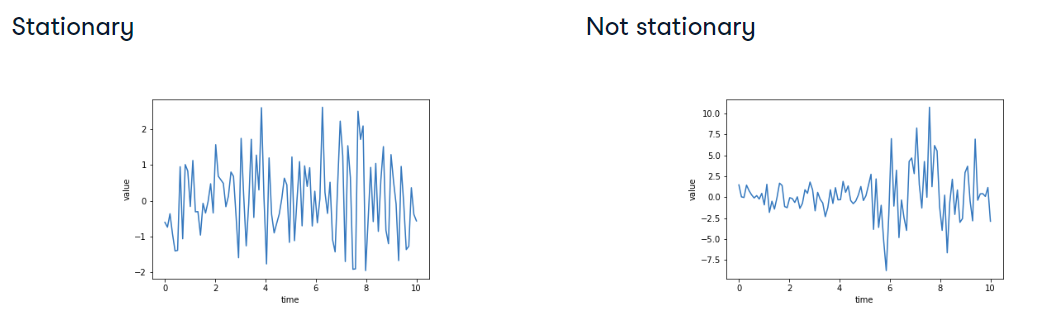
 - Autocorrelation is constant, how each value in times series is related to it's neighbors stays the same
 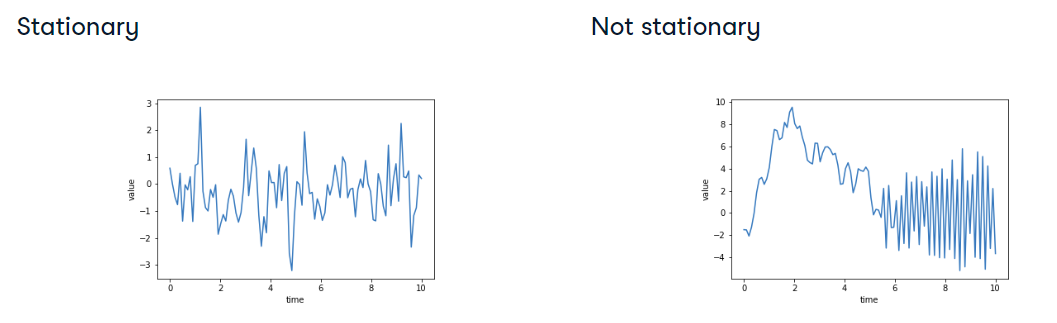

## Making time series stationary
#### Augmented Dicky-Fuller Test
 - A statistical test, where null hypothesis is that your time series is non-stationary due to trend.

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
results = adfuller(df['Generation'])

### Test results
#### 0th element: Test statistic
- More negative means more likely to be stationary

#### 1st element: p-value
- if p-value is small(0.05) -> reject null hypothesis. Reject non-stationary (assume that our time series must be stationary)

#### 4th element: Critical test statistics
 - test statistic value for p-value to be 0.05

In [ ]:
print('p-value: ',results[1])
print('test statstic:', results[0])

Since our p-value is not small(0.05), we cannot reject the null hypothesis so our data is non-stationary

### Non-stationary -> stationary
how? By taking the difference
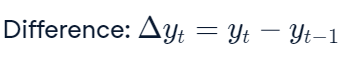

In [ ]:
df_stationary = df.diff().dropna()

In [ ]:
fig, ax = plt.subplots()
df_stationary.plot(ax=ax)
plt.title('Electricity Generation difference (Industry)')
plt.ylabel('𐤃 Generation')
plt.show()

In [ ]:
results = adfuller(df_stationary['Generation'])

In [ ]:
results

In [ ]:
df_nplog = df.apply(np.log)

In [ ]:
df_nplog

In [ ]:
fig, ax = plt.subplots()
df_nplog.plot(ax=ax)
plt.title('Electricity Generation difference (Industry)')
plt.ylabel('𐤃 Generation')
plt.show()

In [ ]:
results = adfuller(df_nplog['Generation'])

In [ ]:
results

In [ ]:
df_transformed = pd.Series(np.log(df['Generation'])).diff().dropna()

In [ ]:
fig, ax = plt.subplots()
df_transformed.plot(ax=ax)
plt.title('Electricity Generation difference (Industry)')
plt.ylabel('𐤃 Generation')
plt.show()

In [ ]:
results = adfuller(df_transformed)

In [ ]:
results

# Autoregressive (AR) Models:
#### AR(1) Model:
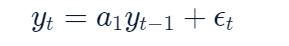
- eplison-t = white noise
- a1 is the autoregressive coefficient at lag one

#### AR(p) model:
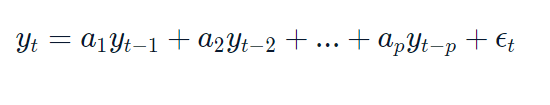


# Moving average (MA) Models:
#### MA(1) Model:
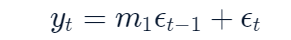
- m1 is the moving average coefficient



### Time series forecasting with XGBoost

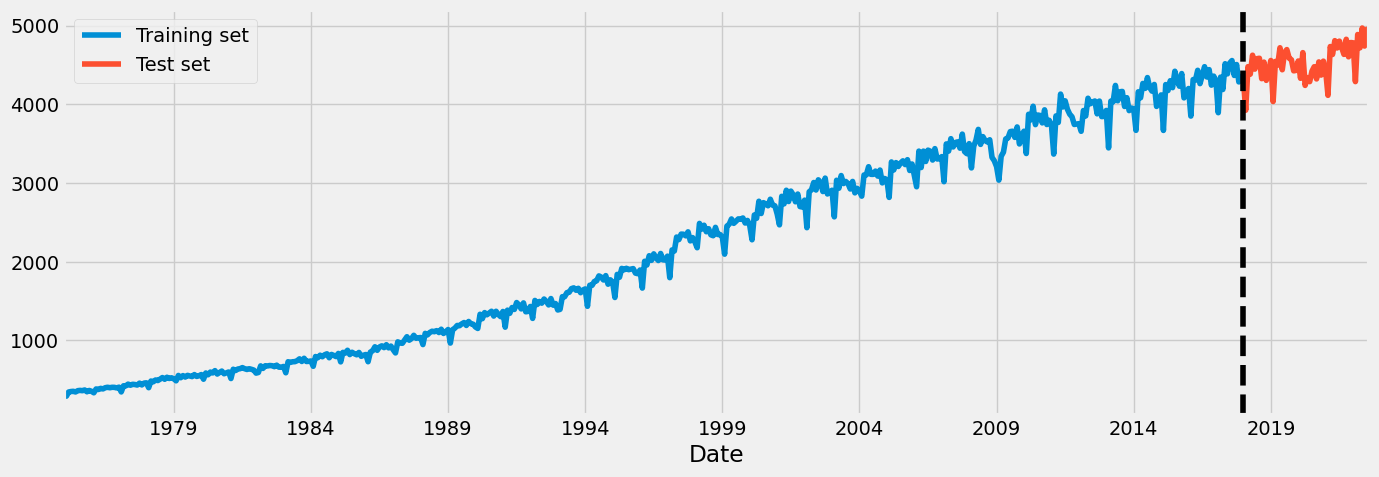

In [16]:
train = df.loc[df.index < '2018-01-01']
test = df.loc[df.index >= '2018-01-01']

fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,label='Train')
test.plot(ax=ax,label='Test')
ax.axvline('2018-01-01', color='black',ls='--')
ax.legend(['Training set','Test set'])
plt.show()

In [17]:
def create_features(df):
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

In [18]:
df = create_features(df)

In [19]:
df.dtypes

Generation    float64
quarter         int64
month           int64
year            int64
dtype: object

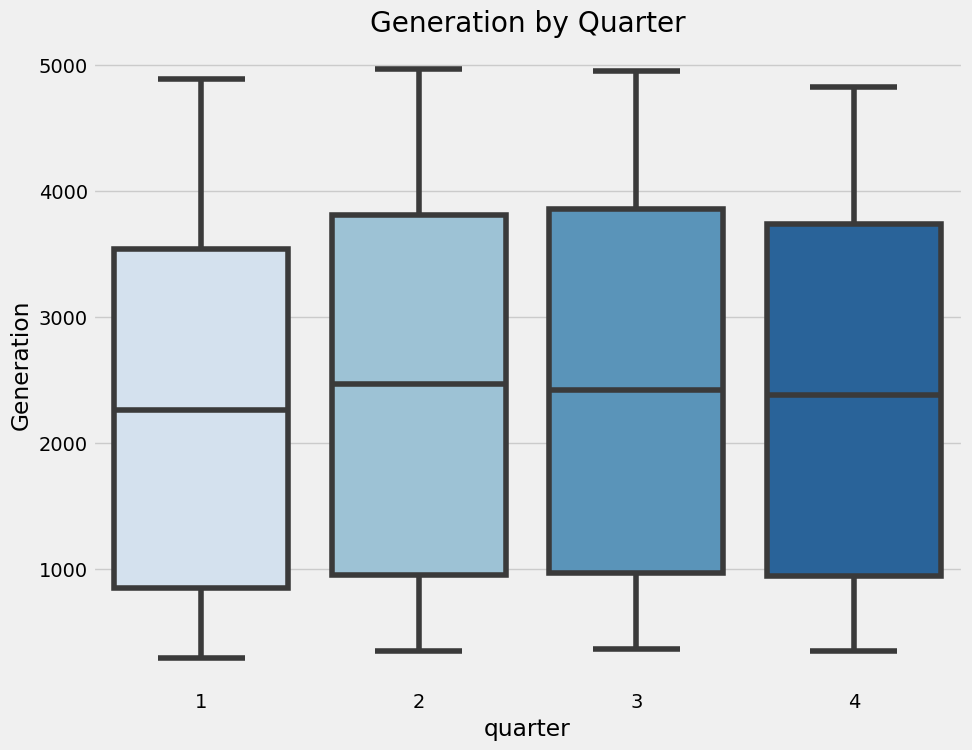

In [20]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='quarter',y='Generation',palette='Blues')
ax.set_title('Generation by Quarter')
plt.show()

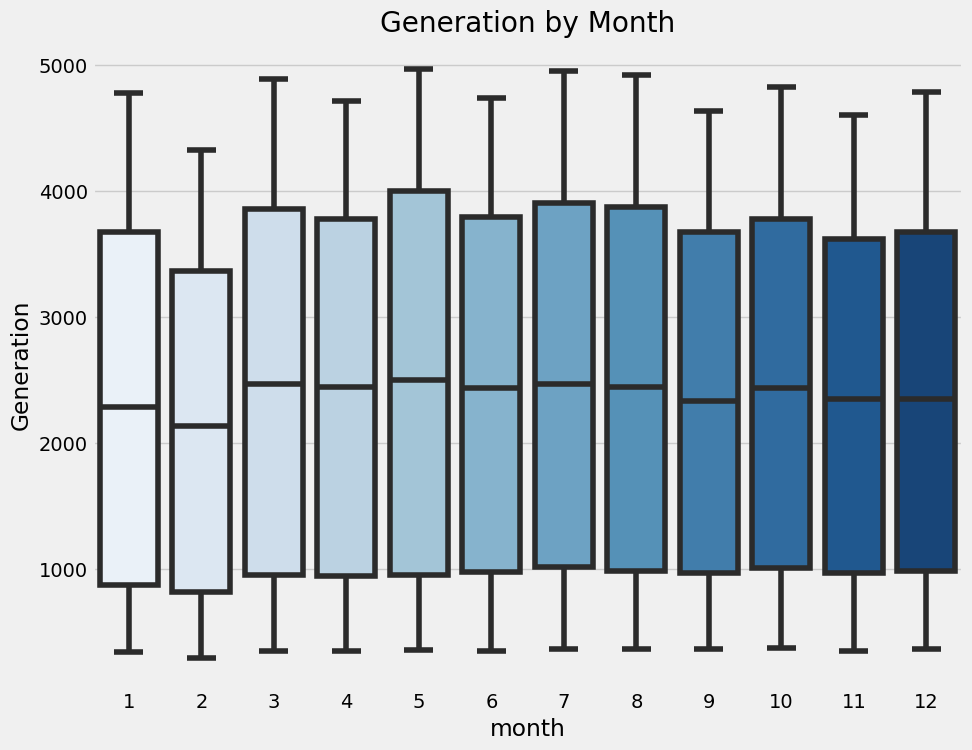

In [21]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='month',y='Generation',palette='Blues')
ax.set_title('Generation by Month')
plt.show() 

In [22]:
train = create_features(train)

C:\Users\Laddi\AppData\Local\Temp\ipykernel_26048\4199984062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
C:\Users\Laddi\AppData\Local\Temp\ipykernel_26048\4199984062.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
C:\Users\Laddi\AppData\Local\Temp\ipykernel_26048\4199984062.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [23]:
test = create_features(test)

C:\Users\Laddi\AppData\Local\Temp\ipykernel_26048\4199984062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
C:\Users\Laddi\AppData\Local\Temp\ipykernel_26048\4199984062.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
C:\Users\Laddi\AppData\Local\Temp\ipykernel_26048\4199984062.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [24]:
FEATURES = ['month','quarter','year']
TARGET = 'Generation'

In [25]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Create Model

In [26]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=10,learning_rate=0.01)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],
      verbose=True)

[0]	validation_0-rmse:2498.78876	validation_1-rmse:4503.27138
[1]	validation_0-rmse:2474.29126	validation_1-rmse:4463.55095
[2]	validation_0-rmse:2450.03643	validation_1-rmse:4424.22447
[3]	validation_0-rmse:2426.02153	validation_1-rmse:4385.28803
[4]	validation_0-rmse:2402.22847	validation_1-rmse:4348.17381
[5]	validation_0-rmse:2378.68662	validation_1-rmse:4309.99156
[6]	validation_0-rmse:2355.37761	validation_1-rmse:4272.18823
[7]	validation_0-rmse:2332.28494	validation_1-rmse:4236.16479
[8]	validation_0-rmse:2309.43526	validation_1-rmse:4199.09392
[9]	validation_0-rmse:2286.81168	validation_1-rmse:4162.39077
[10]	validation_0-rmse:2264.41231	validation_1-rmse:4126.05171
[11]	validation_0-rmse:2242.22034	validation_1-rmse:4091.43177
[12]	validation_0-rmse:2220.26210	validation_1-rmse:4055.79697
[13]	validation_0-rmse:2198.52098	validation_1-rmse:4020.51566
[14]	validation_0-rmse:2176.99551	validation_1-rmse:3985.58441
[15]	validation_0-rmse:2155.67027	validation_1-rmse:3952.31384
[1

[131]	validation_0-rmse:694.60946	validation_1-rmse:1535.98286
[132]	validation_0-rmse:687.93957	validation_1-rmse:1524.15822
[133]	validation_0-rmse:681.33197	validation_1-rmse:1513.22179
[134]	validation_0-rmse:674.78153	validation_1-rmse:1501.62278
[135]	validation_0-rmse:668.30412	validation_1-rmse:1490.89905
[136]	validation_0-rmse:661.89165	validation_1-rmse:1480.28202
[137]	validation_0-rmse:655.54208	validation_1-rmse:1468.67406
[138]	validation_0-rmse:649.25568	validation_1-rmse:1458.26386
[139]	validation_0-rmse:643.03729	validation_1-rmse:1446.87287
[140]	validation_0-rmse:636.87311	validation_1-rmse:1435.59468
[141]	validation_0-rmse:630.77232	validation_1-rmse:1424.74864
[142]	validation_0-rmse:624.73456	validation_1-rmse:1414.90081
[143]	validation_0-rmse:618.74934	validation_1-rmse:1404.26016
[144]	validation_0-rmse:612.82675	validation_1-rmse:1394.44294
[145]	validation_0-rmse:606.96267	validation_1-rmse:1383.68291
[146]	validation_0-rmse:601.15590	validation_1-rmse:137

[263]	validation_0-rmse:201.60133	validation_1-rmse:642.28139
[264]	validation_0-rmse:199.80724	validation_1-rmse:639.09292
[265]	validation_0-rmse:198.03688	validation_1-rmse:635.47955
[266]	validation_0-rmse:196.26454	validation_1-rmse:632.15024
[267]	validation_0-rmse:194.53455	validation_1-rmse:628.60667
[268]	validation_0-rmse:192.80033	validation_1-rmse:625.46629
[269]	validation_0-rmse:191.08012	validation_1-rmse:622.22753
[270]	validation_0-rmse:189.39188	validation_1-rmse:618.78322
[271]	validation_0-rmse:187.70868	validation_1-rmse:615.61347
[272]	validation_0-rmse:186.04472	validation_1-rmse:612.59503
[273]	validation_0-rmse:184.40656	validation_1-rmse:609.24701
[274]	validation_0-rmse:182.78484	validation_1-rmse:606.16369
[275]	validation_0-rmse:181.19254	validation_1-rmse:602.88030
[276]	validation_0-rmse:179.61007	validation_1-rmse:599.63036
[277]	validation_0-rmse:178.03310	validation_1-rmse:596.77946
[278]	validation_0-rmse:176.47693	validation_1-rmse:593.85218
[279]	va

[396]	validation_0-rmse:71.34653	validation_1-rmse:382.16360
[397]	validation_0-rmse:70.89929	validation_1-rmse:381.21692
[398]	validation_0-rmse:70.46874	validation_1-rmse:380.19429
[399]	validation_0-rmse:70.03518	validation_1-rmse:379.26544
[400]	validation_0-rmse:69.59917	validation_1-rmse:378.24409
[401]	validation_0-rmse:69.17156	validation_1-rmse:377.33286
[402]	validation_0-rmse:68.75602	validation_1-rmse:376.44576
[403]	validation_0-rmse:68.34233	validation_1-rmse:375.43342
[404]	validation_0-rmse:67.93693	validation_1-rmse:374.56313
[405]	validation_0-rmse:67.53276	validation_1-rmse:373.58431
[406]	validation_0-rmse:67.12624	validation_1-rmse:372.61503
[407]	validation_0-rmse:66.72235	validation_1-rmse:371.74361
[408]	validation_0-rmse:66.32177	validation_1-rmse:370.88077
[409]	validation_0-rmse:65.92677	validation_1-rmse:369.93584
[410]	validation_0-rmse:65.53657	validation_1-rmse:368.99892
[411]	validation_0-rmse:65.15871	validation_1-rmse:368.07146
[412]	validation_0-rmse:

[531]	validation_0-rmse:38.84148	validation_1-rmse:300.88356
[532]	validation_0-rmse:38.72888	validation_1-rmse:300.50628
[533]	validation_0-rmse:38.61265	validation_1-rmse:300.19908
[534]	validation_0-rmse:38.49624	validation_1-rmse:299.89787
[535]	validation_0-rmse:38.38375	validation_1-rmse:299.61707
[536]	validation_0-rmse:38.27289	validation_1-rmse:299.34510
[537]	validation_0-rmse:38.16225	validation_1-rmse:299.07516
[538]	validation_0-rmse:38.05469	validation_1-rmse:298.77834
[539]	validation_0-rmse:37.94442	validation_1-rmse:298.48738
[540]	validation_0-rmse:37.83919	validation_1-rmse:298.21654
[541]	validation_0-rmse:37.72897	validation_1-rmse:297.94123
[542]	validation_0-rmse:37.62807	validation_1-rmse:297.66278
[543]	validation_0-rmse:37.52081	validation_1-rmse:297.39683
[544]	validation_0-rmse:37.41469	validation_1-rmse:297.13295
[545]	validation_0-rmse:37.31139	validation_1-rmse:296.87118
[546]	validation_0-rmse:37.21912	validation_1-rmse:296.61808
[547]	validation_0-rmse:

[666]	validation_0-rmse:29.43364	validation_1-rmse:274.48887
[667]	validation_0-rmse:29.38907	validation_1-rmse:274.36972
[668]	validation_0-rmse:29.35104	validation_1-rmse:274.24428
[669]	validation_0-rmse:29.30394	validation_1-rmse:274.14109
[670]	validation_0-rmse:29.26663	validation_1-rmse:274.01738
[671]	validation_0-rmse:29.22708	validation_1-rmse:273.91555
[672]	validation_0-rmse:29.18544	validation_1-rmse:273.79338
[673]	validation_0-rmse:29.14439	validation_1-rmse:273.67231
[674]	validation_0-rmse:29.10393	validation_1-rmse:273.55226
[675]	validation_0-rmse:29.07083	validation_1-rmse:273.43318
[676]	validation_0-rmse:29.03818	validation_1-rmse:273.31492
[677]	validation_0-rmse:29.00596	validation_1-rmse:273.19762
[678]	validation_0-rmse:28.97419	validation_1-rmse:273.08129
[679]	validation_0-rmse:28.94289	validation_1-rmse:272.96591
[680]	validation_0-rmse:28.91200	validation_1-rmse:272.85145
[681]	validation_0-rmse:28.87303	validation_1-rmse:272.73793
[682]	validation_0-rmse:

[801]	validation_0-rmse:25.05028	validation_1-rmse:263.70255
[802]	validation_0-rmse:25.02991	validation_1-rmse:263.66307
[803]	validation_0-rmse:25.00255	validation_1-rmse:263.62380
[804]	validation_0-rmse:24.98040	validation_1-rmse:263.58479
[805]	validation_0-rmse:24.96049	validation_1-rmse:263.54604
[806]	validation_0-rmse:24.93353	validation_1-rmse:263.50750
[807]	validation_0-rmse:24.91183	validation_1-rmse:263.46922
[808]	validation_0-rmse:24.89237	validation_1-rmse:263.43110
[809]	validation_0-rmse:24.86627	validation_1-rmse:263.38632
[810]	validation_0-rmse:24.84051	validation_1-rmse:263.34186
[811]	validation_0-rmse:24.81646	validation_1-rmse:263.29774
[812]	validation_0-rmse:24.79117	validation_1-rmse:263.25398
[813]	validation_0-rmse:24.76620	validation_1-rmse:263.21053
[814]	validation_0-rmse:24.74299	validation_1-rmse:263.16741
[815]	validation_0-rmse:24.71819	validation_1-rmse:263.12461
[816]	validation_0-rmse:24.69554	validation_1-rmse:263.08212
[817]	validation_0-rmse:

[936]	validation_0-rmse:22.29094	validation_1-rmse:259.87470
[937]	validation_0-rmse:22.27627	validation_1-rmse:259.85730
[938]	validation_0-rmse:22.25784	validation_1-rmse:259.85737
[939]	validation_0-rmse:22.24568	validation_1-rmse:259.83380
[940]	validation_0-rmse:22.23118	validation_1-rmse:259.81055
[941]	validation_0-rmse:22.21602	validation_1-rmse:259.78744
[942]	validation_0-rmse:22.20402	validation_1-rmse:259.76455
[943]	validation_0-rmse:22.18598	validation_1-rmse:259.76674
[944]	validation_0-rmse:22.17413	validation_1-rmse:259.74646
[945]	validation_0-rmse:22.15324	validation_1-rmse:259.72191
[946]	validation_0-rmse:22.13163	validation_1-rmse:259.69757
[947]	validation_0-rmse:22.10702	validation_1-rmse:259.69978
[948]	validation_0-rmse:22.08570	validation_1-rmse:259.67567
[949]	validation_0-rmse:22.05961	validation_1-rmse:259.66248
[950]	validation_0-rmse:22.03779	validation_1-rmse:259.64056
[951]	validation_0-rmse:22.01267	validation_1-rmse:259.62618
[952]	validation_0-rmse:

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [27]:
importance = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
            columns=['Importance'])

In [31]:
importance

,Importance
month,0.002302
quarter,0.000000
year,0.997698


<AxesSubplot: title={'center': 'Feature Importance'}>

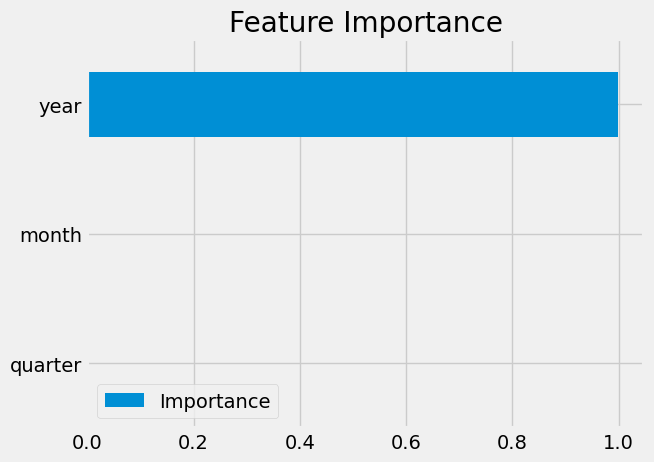

In [30]:
importance.sort_values('Importance').plot(kind='barh',title='Feature Importance')

# Forecast on Test

In [32]:
test['prediction']=reg.predict(X_test)

C:\Users\Laddi\AppData\Local\Temp\ipykernel_26048\716901839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction']=reg.predict(X_test)


In [33]:
df = df.merge(test['prediction'],how='left',left_index=True,right_index=True)

In [34]:
df.columns

Index(['Generation', 'quarter', 'month', 'year', 'prediction'], dtype='object')

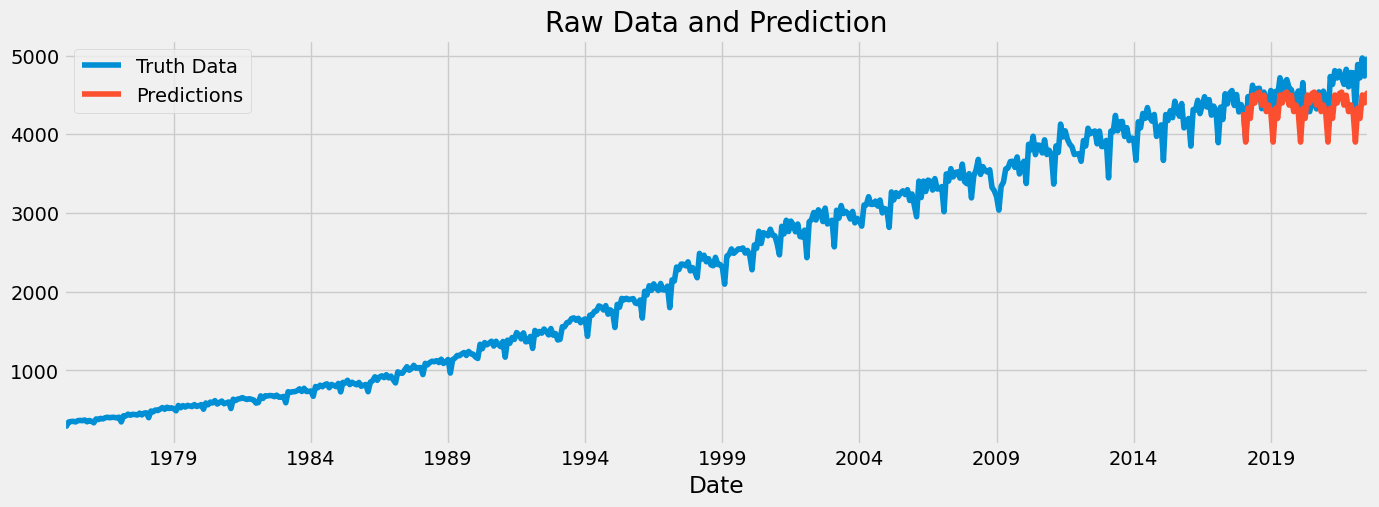

In [36]:
ax= df[['Generation']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax)
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
np.sqrt(mean_squared_error(test['Generation'],test['prediction']))